Import the required dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from si_prefix import si_format
import types

In [2]:
# Insert custom values for the PLL
Fref = 125e6  # Reference Frequency
N = 20  # Multiplication Factor
Rz = 8e3  # Zero Resistor Value
Icp = 90e-6  # Charge Pump current
tau = 120e-12  # Charge Pump Pulse
KVCO_HzV = 1.8e9  # VCO Gain in Hz/V
Cunit = 1e-12  # Unitary Capacitor for Capacitor ratio
C1 = 24 * Cunit
C2 = 0.5 * Cunit

Now we calculate the main parameteres

In [3]:
# PLL calculations
f0 = Fref * N  # Output Frequency
KVCOrad = (2 * np.pi) * KVCO_HzV  # VCO gain in rad/s
KVCO = KVCOrad  # For future calculations
KPD = Icp / (2 * np.pi)  # Charge pump Gain
print('KVCO: '+si_format(KVCO_HzV)+'Hz/V')
print('KPD: '+si_format(KPD)+'A/V')
print('f0: '+si_format(f0)+'Hz')

KVCO: 1.8 GHz/V
KPD: 14.3 µA/V
f0: 2.5 GHz


Open loop and closed loop transfer function calculations

In [4]:
# Transfer function
#               n0 + n1s   
# H(s) = ------------------------
#        d0 + d1s + d2s^2 + d3s^3

#               n1s + n0   
# H(s) = ------------------------
#        d3s^3 + d2s^2 + d1s + d0
# n0 = KPD * KVCO
# n1 = C1 * KPD * KVCO * Rz
# d0 = 0
# d1 = 0
# d2 = (C1 + C2) * N
# d3 = C1 * C2 * N * Rz

# Frequency Response
f = np.logspace(3, 9, num=1000)  # Frequency range from 1kHz to 1GHz
w = 2 * np.pi * f  # Angular frequency

# Open Loop
LG = types.SimpleNamespace()
LG.n0 = KPD * KVCO
LG.n1 = C1 * KPD * KVCO * Rz
LG.d0 = 0
LG.d1 = 0
LG.d2 = (C1 + C2) * N
LG.d3 = C1 * C2 * N * Rz
LG.num = [LG.n1, LG.n0]
LG.den = [LG.d3, LG.d2, LG.d1, LG.d0]

# Closed Loop
CL = types.SimpleNamespace()
CL.n0 = KPD * KVCO * N
CL.n1 = C1 * KPD * KVCO * N * Rz
CL.d0 = KPD * KVCO
CL.d1 = C1 * KPD * KVCO * Rz
CL.d2 = C1 * N + C2 * N
CL.d3 = C1 * C2 * N * Rz
CL.num = [CL.n1, CL.n0]
CL.den = [CL.d3, CL.d2, CL.d1, CL.d0]

# Open Loop Frequency Response (magnitude and phase)
w, H_LG = sp.signal.freqs(LG.num, LG.den, w)
H_LG_mag_db = 20 * np.log10(np.abs(H_LG))
H_LG_phase_deg = np.unwrap(np.angle(H_LG)) * 180.0 / np.pi

#Gain bandwidth calculation
# Find frequency where magnitude crosses 0 dB
gain_bandwidth = np.nan
for i in range(1, len(H_LG_mag_db)):
    if H_LG_mag_db[i-1] > 0 and H_LG_mag_db[i] <= 0:
        # Linear interpolation to find exact crossover frequency
        f1 = f[i-1]
        f2 = f[i]
        mag1 = H_LG_mag_db[i-1]
        mag2 = H_LG_mag_db[i]
        gain_bandwidth = f1 + (0 - mag1) * (f2 - f1) / (mag2 - mag1)
        break
if np.isfinite(gain_bandwidth):
    print('Gain Bandwidth: ' + si_format(gain_bandwidth) + 'Hz')

#Phase Margin calculation
# Find phase at gain crossover frequency
phase_margin = np.nan
if np.isfinite(gain_bandwidth):
    for i in range(1, len(f)):
        if f[i-1] < gain_bandwidth <= f[i]:
            phase1 = H_LG_phase_deg[i-1]
            phase2 = H_LG_phase_deg[i]
            phase_at_gbw = phase1 + (gain_bandwidth - f[i-1]) * (phase2 - phase1) / (f[i] - f[i-1])
            phase_margin = 180 + phase_at_gbw  # PM = 180 + phase at crossover
            break
if np.isfinite(phase_margin):
    print('Phase Margin: ' + si_format(phase_margin) + ' degrees')

# Closed Loop Frequency Response (magnitude)
w, H_CL = sp.signal.freqs(CL.num, CL.den, w)
H_CL_mag_db = 20 * np.log10(np.abs(H_CL))

# Closed Loop step response (time-domain)
# choose a time vector that spans a few natural periods based on f0
t = np.linspace(0, 5 / gain_bandwidth, 1000)
t_out, H_CL_step = sp.signal.step((CL.num, CL.den), T=t)

# Compute settling time (2% criterion) directly from the step response arrays
final_value = H_CL_step[-1]
tol = 0.02 * abs(final_value) if np.isfinite(final_value) and final_value != 0 else 0.02
settling_time = np.nan
for idx in range(len(H_CL_step)):
	if np.all(np.abs(H_CL_step[idx:] - final_value) <= tol):
		settling_time = t_out[idx]
		break
if np.isfinite(settling_time):
	print('Settling time (2% criterion): ' + si_format(settling_time) + 's')
else:
	print('Settling time (2% criterion): N/A')

Gain Bandwidth: 9.9 MHz
Phase Margin: 71.6  degrees
Settling time (2% criterion): 247.4 ns


Plot results

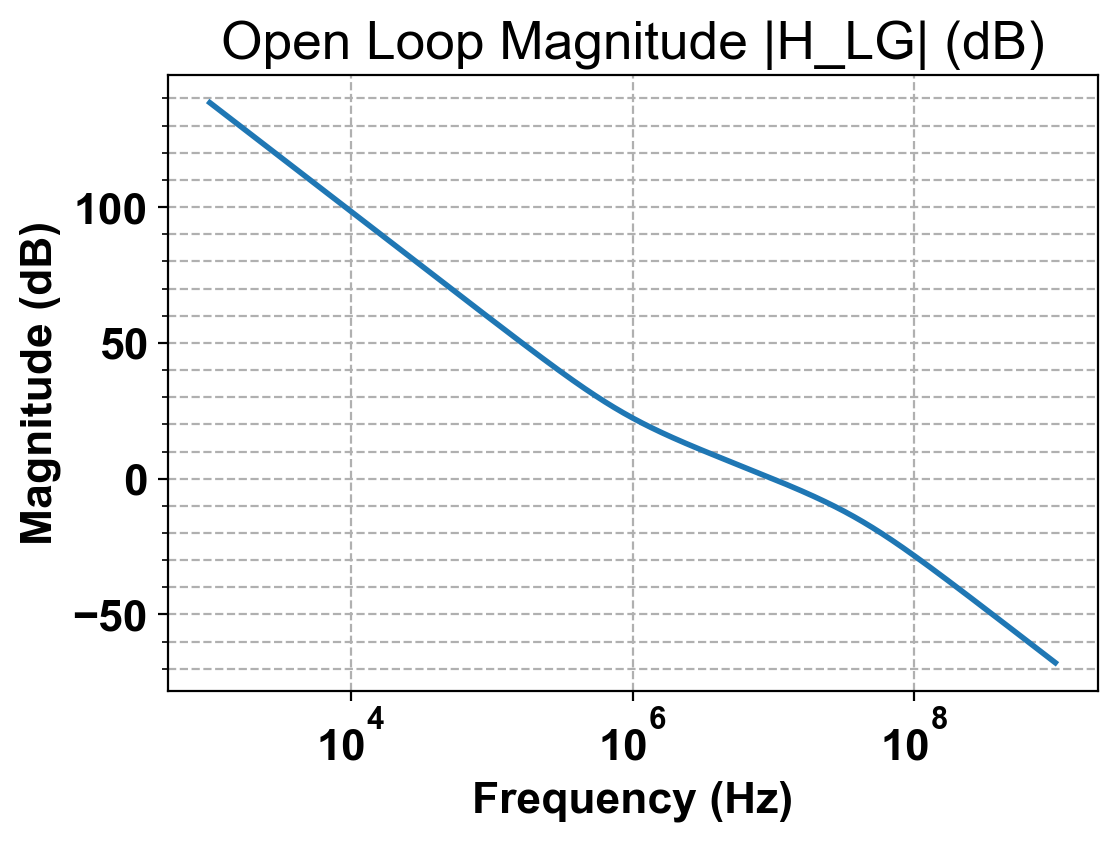

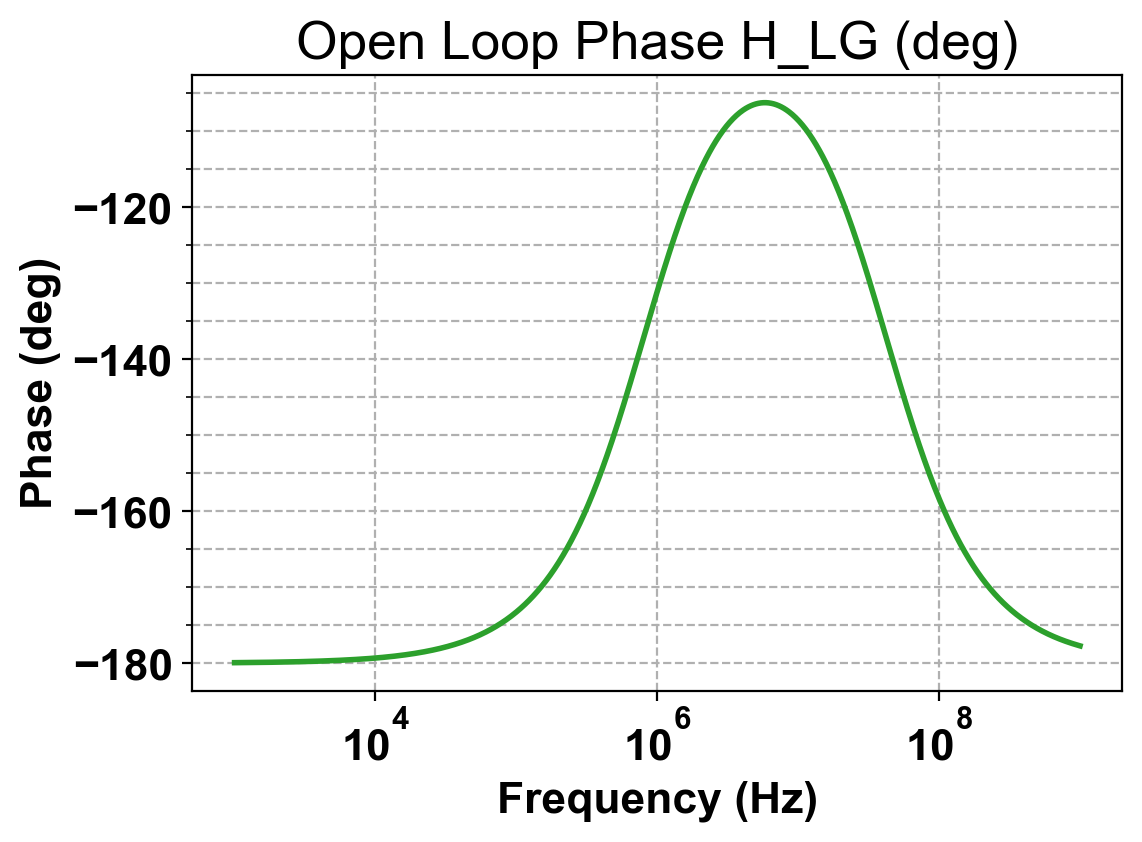

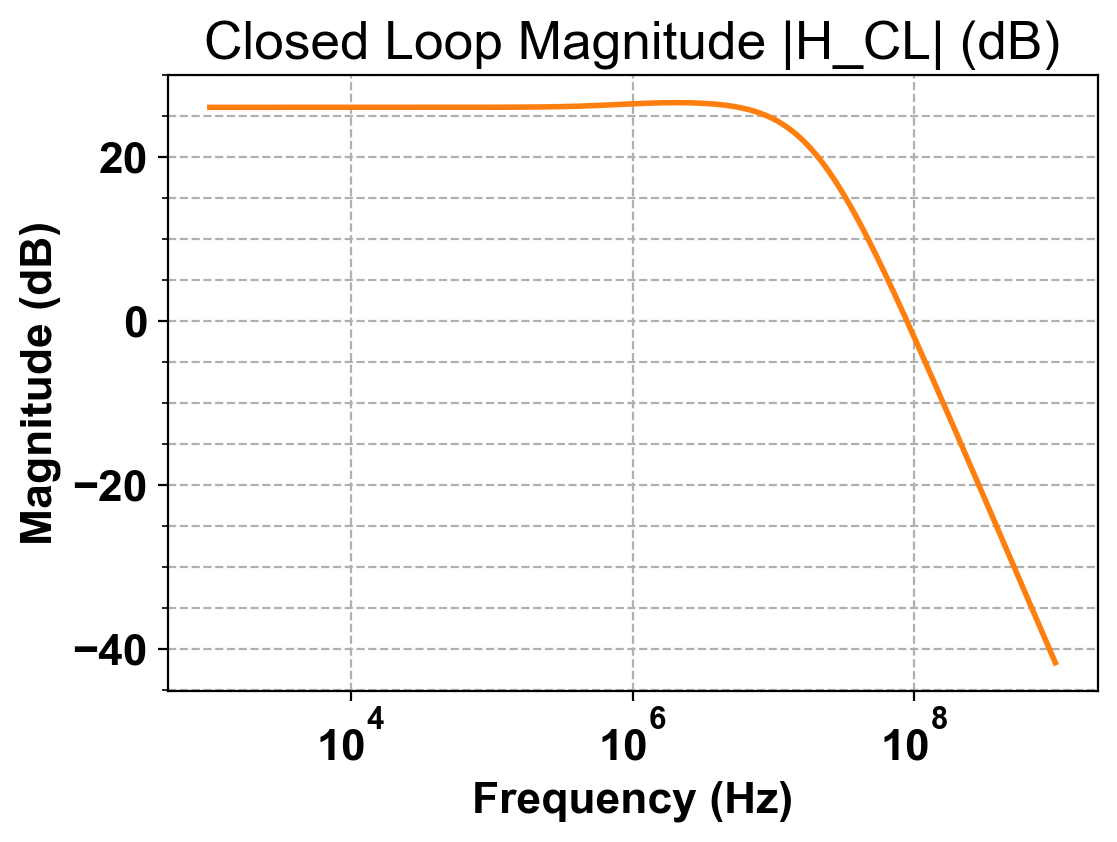

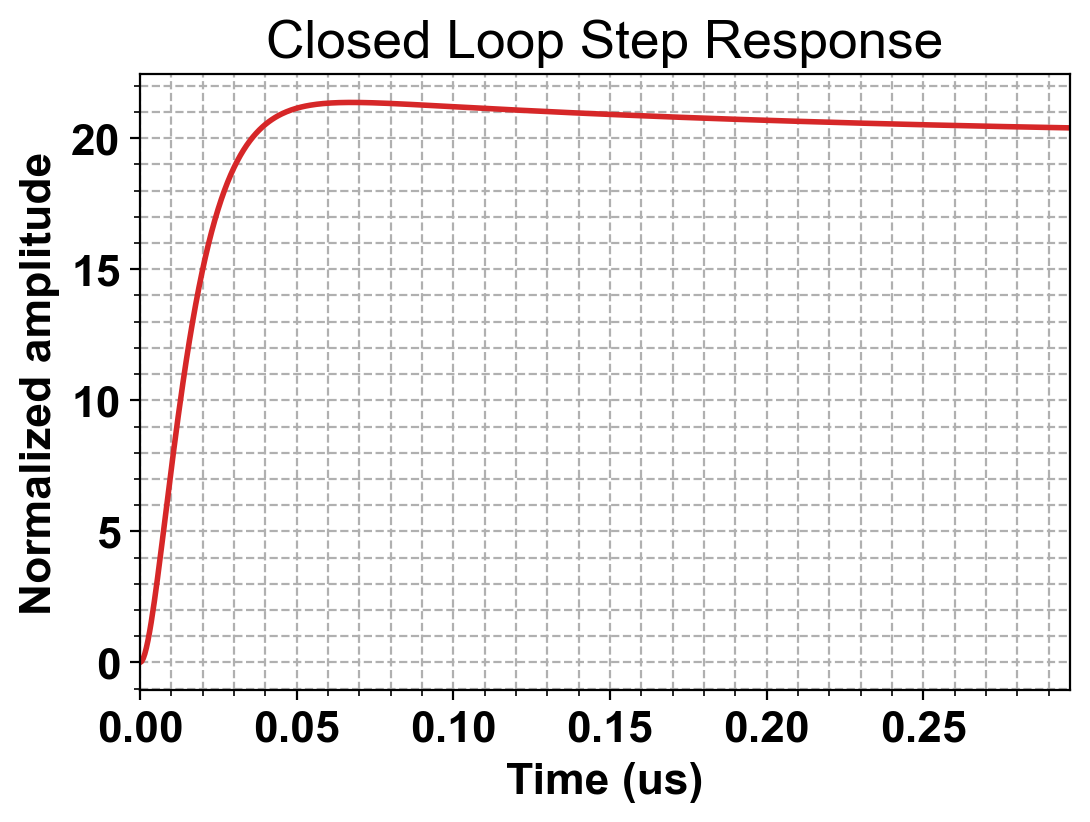

In [7]:
# Set font properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 'bold'

# Plot Open Loop magnitude
plt.figure(figsize=(6, 4), dpi=200)
plt.minorticks_on()
plt.semilogx(f, H_LG_mag_db, color='tab:blue', linewidth=2)
plt.title('Open Loop Magnitude |H_LG| (dB)')
plt.xlabel('Frequency (Hz)', fontweight='bold')
plt.ylabel('Magnitude (dB)', fontweight='bold')
plt.grid(True, linestyle='--', which='both')
plt.show()

# Plot Open Loop phase
plt.figure(figsize=(6, 4), dpi=200)
plt.minorticks_on()
plt.semilogx(f, H_LG_phase_deg, color='tab:green', linewidth=2)
plt.title('Open Loop Phase H_LG (deg)')
plt.xlabel('Frequency (Hz)', fontweight='bold')
plt.ylabel('Phase (deg)', fontweight='bold')
plt.grid(True, linestyle='--', which='both')
plt.show()

# Plot Closed Loop magnitude
plt.figure(figsize=(6, 4), dpi=200)
plt.minorticks_on()
plt.semilogx(f, H_CL_mag_db, color='tab:orange', linewidth=2)
plt.title('Closed Loop Magnitude |H_CL| (dB)')
plt.xlabel('Frequency (Hz)', fontweight='bold')
plt.ylabel('Magnitude (dB)', fontweight='bold')
plt.grid(True, linestyle='--', which='both')
plt.show()

# Plot Closed Loop step response
plt.figure(figsize=(6, 4), dpi=200)
plt.minorticks_on()
plt.plot(t_out * 1e6, H_CL_step, color='tab:red', linewidth=2)
plt.title('Closed Loop Step Response')
plt.xlabel('Time (us)', fontweight='bold')
plt.ylabel('Normalized amplitude', fontweight='bold')
plt.grid(True, linestyle='--', which='both')
plt.xlim([0, 1e6* settling_time * 1.2])  # Focus on settling time region
plt.show()

Now we calculate the transfert function of the Noise Contributions

In [8]:
# Noise Analysis
# Noise transfert functions

#Input Reference Noise Transfer Function
NTF_in = types.SimpleNamespace()
NTF_in.n0 = KPD*KVCO*N
NTF_in.n1 = C1*KPD*KVCO*N*Rz
NTF_in.d0 = KPD*KVCO
NTF_in.d1 = C1*KPD*KVCO*Rz
NTF_in.d2 = C1*N + C2*N
NTF_in.d3 = C1*C2*N*Rz
NTF_in.num = [NTF_in.n1, NTF_in.n0]
NTF_in.den = [NTF_in.d3, NTF_in.d2, NTF_in.d1, NTF_in.d0]

# Charge Pump
NTF_cp = types.SimpleNamespace()
NTF_cp.n0 = KVCO*N
NTF_cp.n1 = C1*KVCO*N*Rz
NTF_cp.d0 = KPD*KVCO
NTF_cp.d1 = C1*KPD*KVCO*Rz
NTF_cp.d2 = C1*N + C2*N
NTF_cp.d3 = C1*C2*N*Rz
NTF_cp.num = [NTF_cp.n1, NTF_cp.n0]
NTF_cp.den = [NTF_cp.d3, NTF_cp.d2, NTF_cp.d1, NTF_cp.d0]

# Loop Filter Resistor Rz
NTF_Rz = types.SimpleNamespace()
NTF_Rz.n0 = 0
NTF_Rz.n1 = (C1 + C2)*KVCO*N
NTF_Rz.n2 = C1*C2*KVCO*N*Rz
NTF_Rz.d0 = KPD*KVCO
NTF_Rz.d1 = C1*KPD*KVCO*Rz
NTF_Rz.d2 = (C1 + C2)*N
NTF_Rz.d3 = C1*C2*N*Rz
NTF_Rz.num = [NTF_Rz.n2, NTF_Rz.n1, NTF_Rz.n0]
NTF_Rz.den = [NTF_Rz.d3, NTF_Rz.d2, NTF_Rz.d1, NTF_Rz.d0]

# Voltage Controlled Oscillator
NTF_vco = types.SimpleNamespace()
NTF_vco.n0 = 0
NTF_vco.n1 = 0
NTF_vco.n2 = (C1 + C2)*N
NTF_vco.n3 = C1*C2*N*Rz
NTF_vco.d0 = KPD*KVCO
NTF_vco.d1 = C1*KPD*KVCO*Rz
NTF_vco.d2 = (C1 + C2)*N
NTF_vco.d3 = C1*C2*N*Rz
NTF_vco.num = [NTF_vco.n3, NTF_vco.n2, NTF_vco.n1, NTF_vco.n0]
NTF_vco.den = [NTF_vco.d3, NTF_vco.d2, NTF_vco.d1, NTF_vco.d0]


# Frequency Response of Noise Transfer Functions
w, NTF_in_H = sp.signal.freqs(NTF_in.num, NTF_in.den, w)
NTF_in_mag_db = 20 * np.log10(np.abs(NTF_in_H))
w, NTF_cp_H = sp.signal.freqs(NTF_cp.num, NTF_cp.den, w)
NTF_cp_mag_db = 20 * np.log10(np.abs(NTF_cp_H))
w, NTF_Rz_H = sp.signal.freqs(NTF_Rz.num, NTF_Rz.den, w)
NTF_Rz_mag_db = 20 * np.log10(np.abs(NTF_Rz_H))
w, NTF_vco_H = sp.signal.freqs(NTF_vco.num, NTF_vco.den, w)
NTF_vco_mag_db = 20 * np.log10(np.abs(NTF_vco_H))

Plot the Transfer funcion of all the Noise Functions

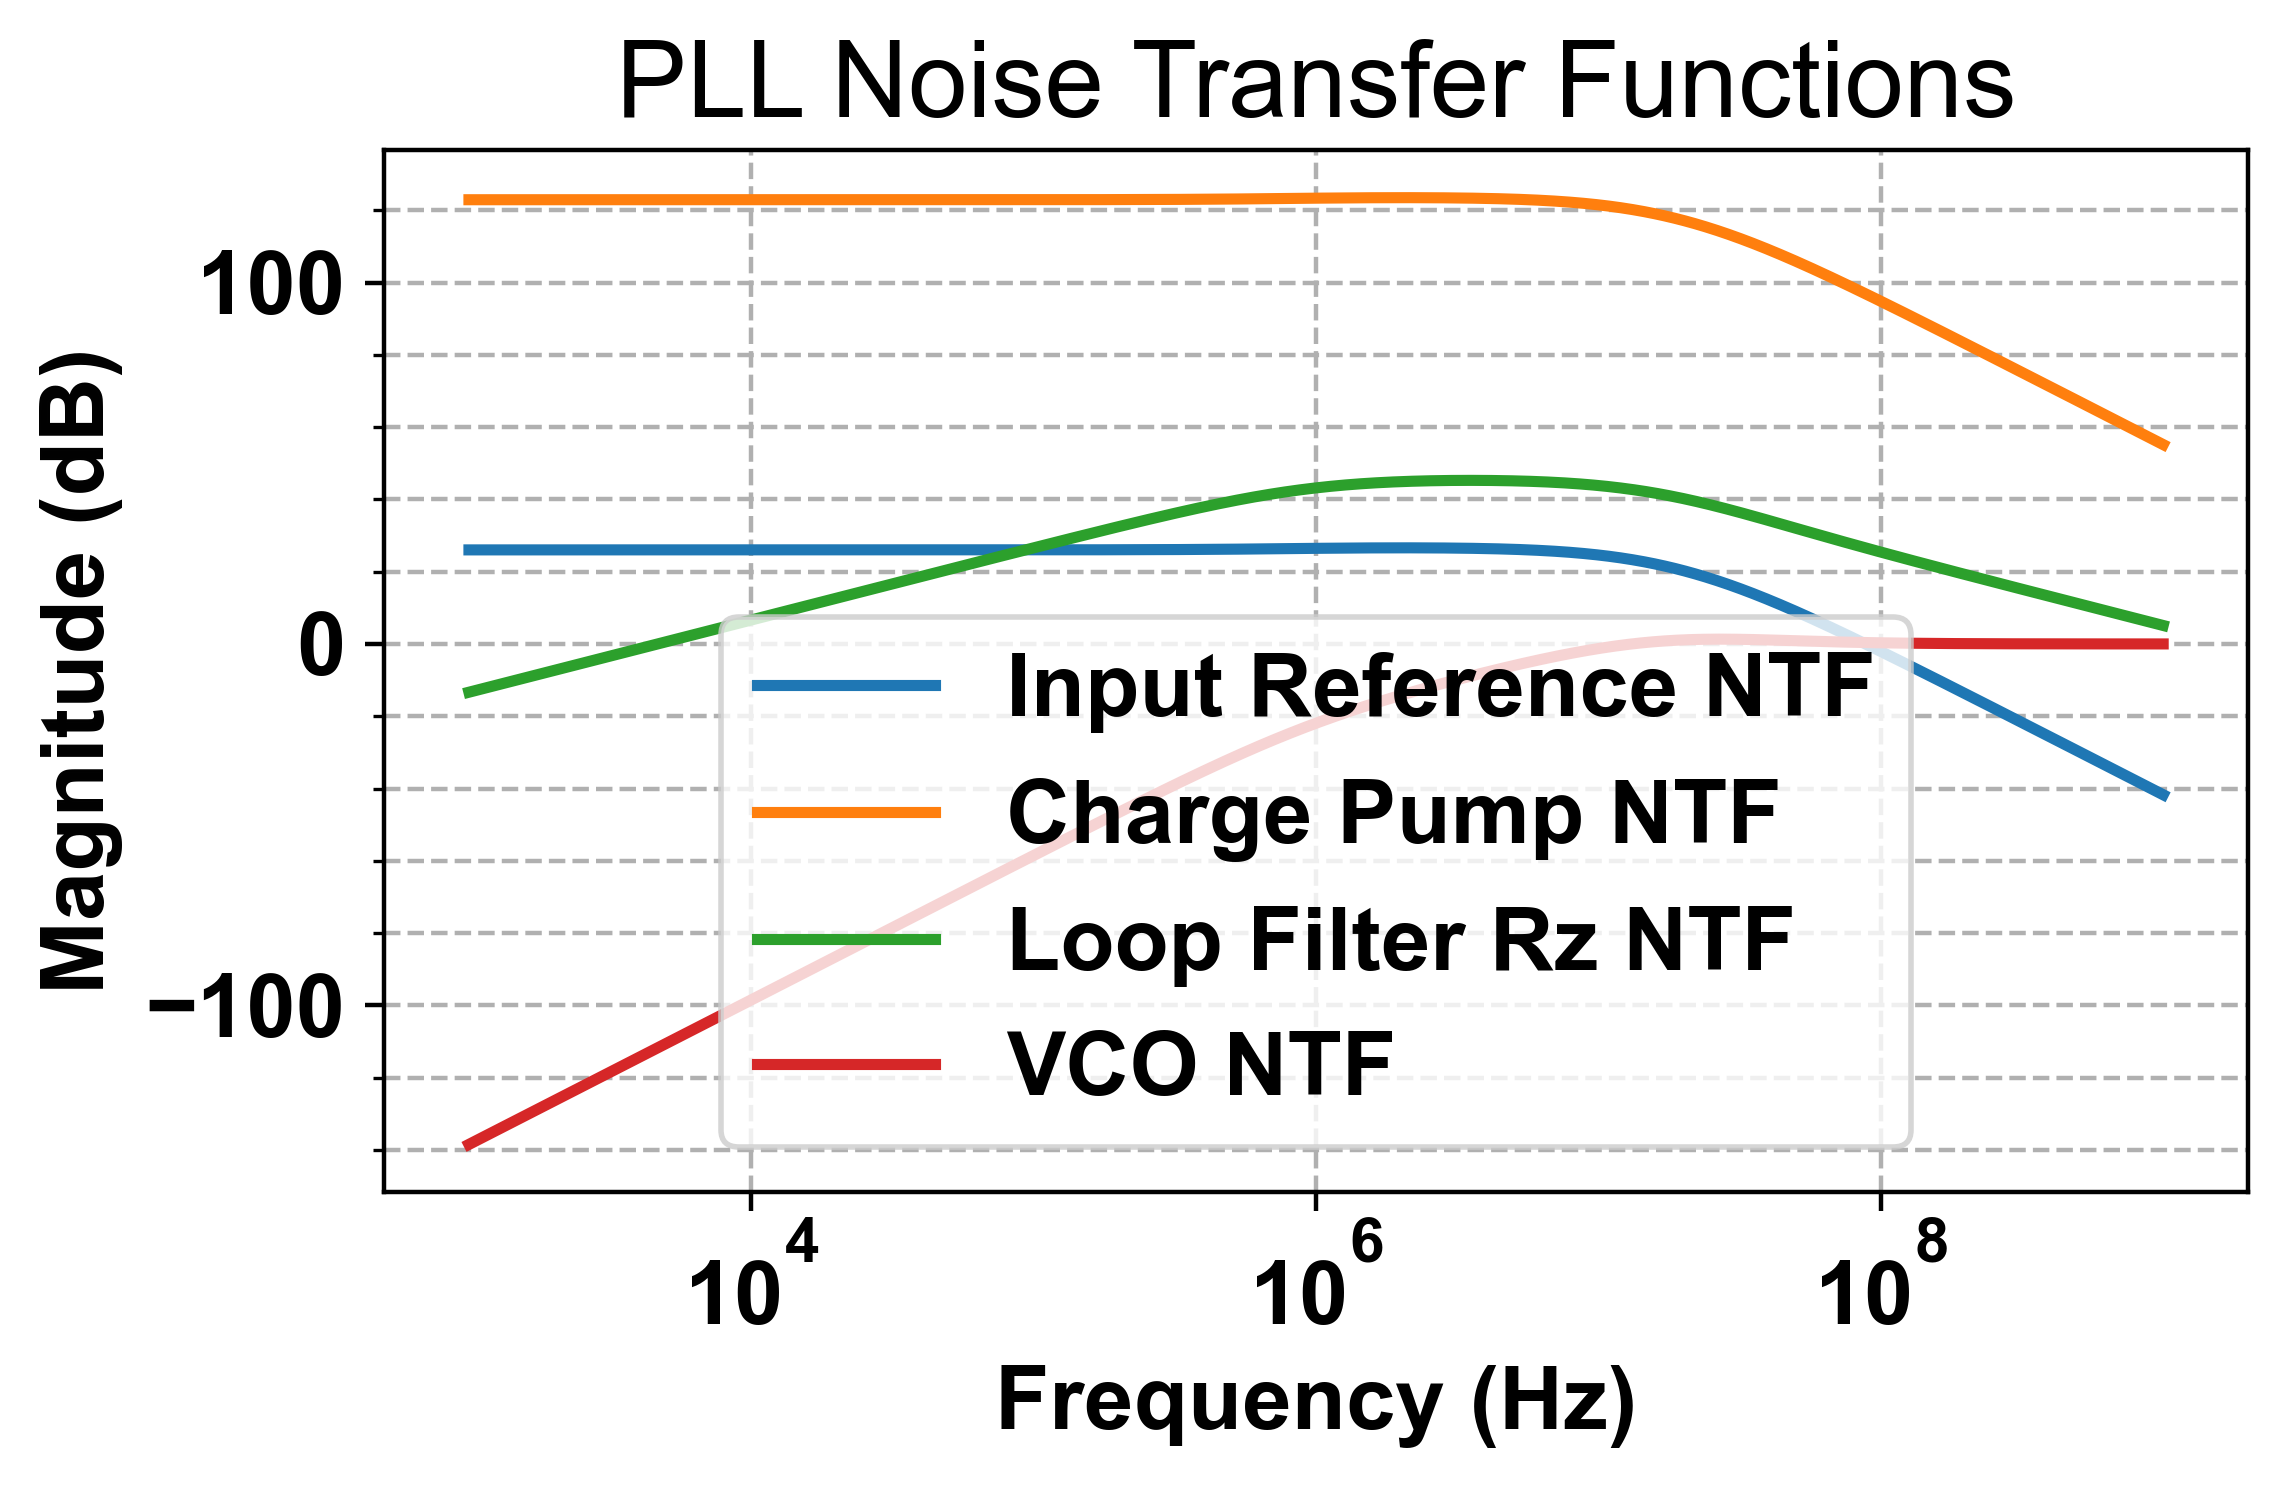

In [10]:
# Plot Noise Transfer Functions
plt.figure(figsize=(6, 4), dpi=400)
plt.minorticks_on()
plt.semilogx(f, NTF_in_mag_db, label='Input Reference NTF', color='tab:blue', linewidth=2)
plt.semilogx(f, NTF_cp_mag_db, label='Charge Pump NTF', color='tab:orange', linewidth=2)
plt.semilogx(f, NTF_Rz_mag_db, label='Loop Filter Rz NTF', color='tab:green', linewidth=2)
plt.semilogx(f, NTF_vco_mag_db, label='VCO NTF', color='tab:red', linewidth=2)
plt.title('PLL Noise Transfer Functions')   
plt.xlabel('Frequency (Hz)', fontweight='bold')
plt.ylabel('Magnitude (dB)', fontweight='bold')
plt.grid(True, linestyle='--', which='both')
plt.legend()
plt.tight_layout()
plt.show()

We add the Noise Sources from simulation data

Input Reference Phase noise
Obtained from the crystal data sheet

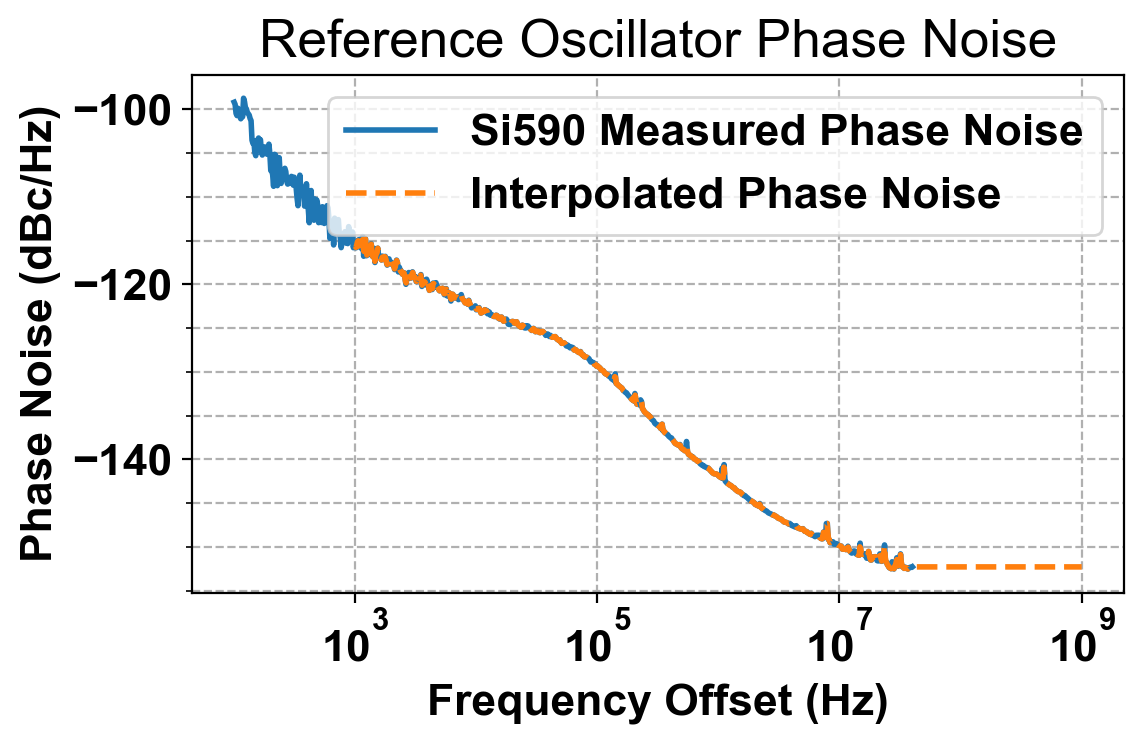

In [12]:
# Noise Sources from data
#Input Reference Phase Noise
tmp = sp.io.loadmat('Si590_CMOS_125MHz_dbcHz.mat')
raw_freq = tmp['frequencyHz'].squeeze()  # Frequency offset vector
raw_phase_noise = tmp['noisedBcHz'].squeeze()  # Phase noise vector
# Interpolate to PLL frequency vector
phase_noise_ref = np.interp(f, raw_freq, raw_phase_noise)

plt.figure(figsize=(6, 4), dpi=200)
plt.minorticks_on()
plt.semilogx(raw_freq, raw_phase_noise, label='Si590 Measured Phase Noise', color='tab:blue', linewidth=2)
plt.semilogx(f, phase_noise_ref, '--', label='Interpolated Phase Noise', color='tab:orange', linewidth=2)
plt.title('Reference Oscillator Phase Noise')
plt.xlabel('Frequency Offset (Hz)', fontweight='bold')
plt.ylabel('Phase Noise (dBc/Hz)', fontweight='bold')
plt.grid(True, linestyle='--', which='both')
plt.legend()
plt.tight_layout()
plt.show()

Charge Pump Noise
The Charge pump noise is obtained from the Current Output Noise, this noise is modulated by the switching of the PFD by a tau/Fref factor

https://ieeexplore.ieee.org/document/9286446
Behzad Razavi's Design of CMOS Phase-Locked Loops (Chapter 8, on noise analysis).

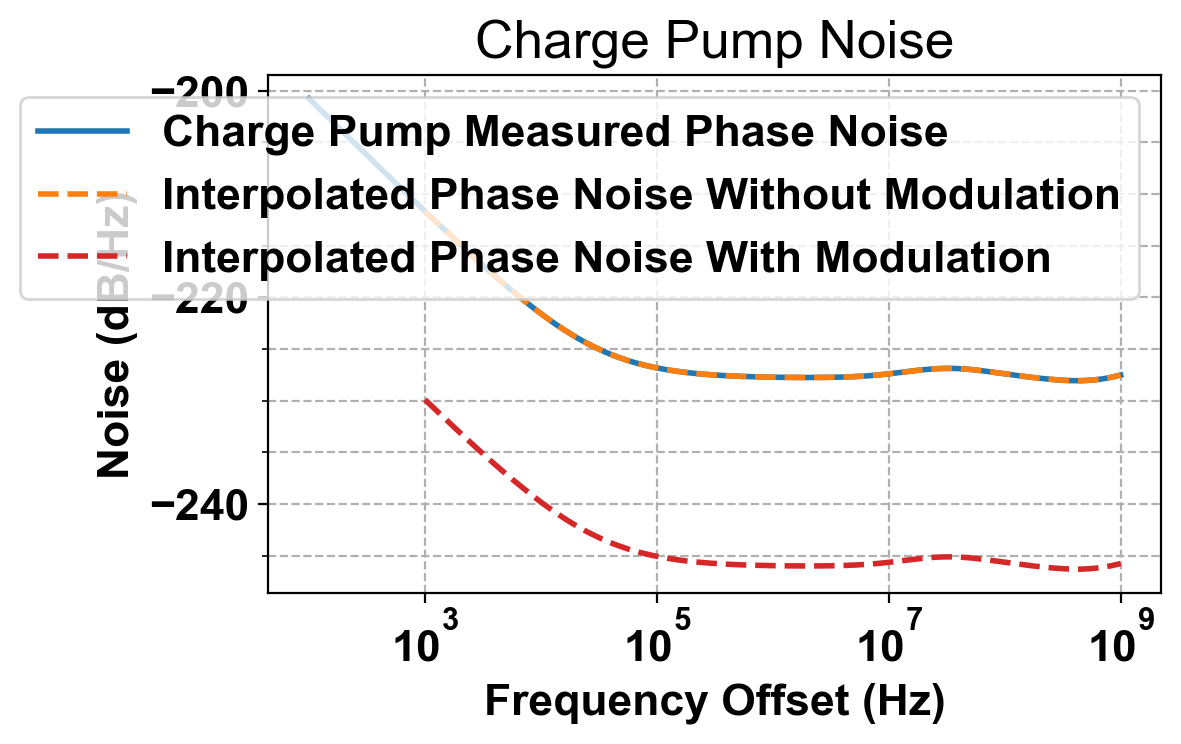

In [14]:
# Charge Pump Noise
tmp = sp.io.loadmat('CP_noise.mat')
raw_freq_cp = tmp['frequencyHz'].squeeze()  # Frequency offset vector
raw_phase_noise_cp = tmp['noisedBHz'].squeeze()  # Phase noise
# Interpolate to PLL frequency vector
phase_noise_cp_womod = np.interp(f, raw_freq_cp, raw_phase_noise_cp)
Tref=1/Fref; #Reference period
cp_mod = 10*np.log10(tau / Tref)  # Charge pump modulation noise
# Add modulation noise to phase noise
phase_noise_cp = phase_noise_cp_womod + cp_mod

plt.figure(figsize=(6, 4), dpi=200)
plt.minorticks_on()
plt.semilogx(raw_freq_cp, raw_phase_noise_cp, label='Charge Pump Measured Phase Noise', color='tab:blue', linewidth=2)
plt.semilogx(f, phase_noise_cp_womod, '--', label='Interpolated Phase Noise Without Modulation', color='tab:orange', linewidth=2)
plt.semilogx(f, phase_noise_cp, '--', label='Interpolated Phase Noise With Modulation', color='tab:red', linewidth=2)
plt.title('Charge Pump Noise')
plt.xlabel('Frequency Offset (Hz)', fontweight='bold')
plt.ylabel('Noise (dB/Hz)', fontweight='bold')
plt.grid(True, linestyle='--', which='both')
plt.legend()
plt.tight_layout()
plt.show()

Voltage Controlled Oscilator
This was measured from the pnoise simulations 

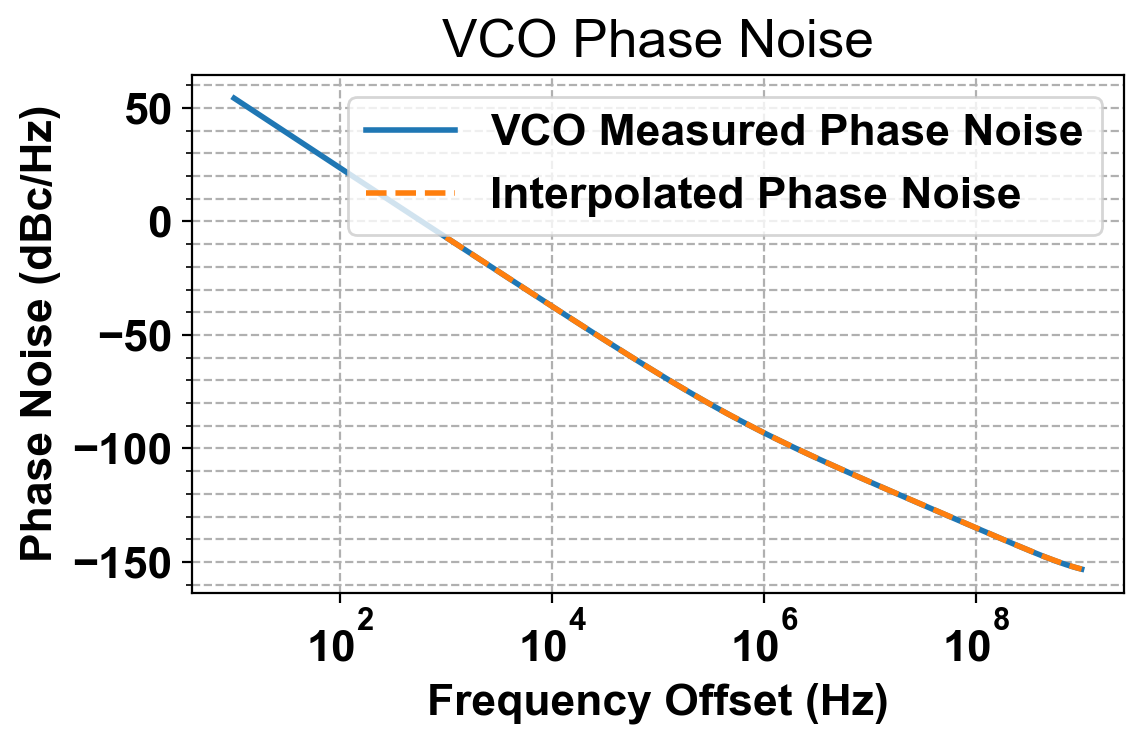

In [16]:
# VCO Noise
tmp = sp.io.loadmat('VCO_phasenoise.mat')
raw_freq_vco = tmp['offset'].squeeze()  # Frequency offset vector
raw_phase_noise_vco = tmp['phasenoise'].squeeze()  # Phase noise
# Interpolate to PLL frequency vector
phase_noise_vco = np.interp(f, raw_freq_vco, raw_phase_noise_vco)

plt.figure(figsize=(6, 4), dpi=200)
plt.minorticks_on()
plt.semilogx(raw_freq_vco, raw_phase_noise_vco, label='VCO Measured Phase Noise', color='tab:blue', linewidth=2)
plt.semilogx(f, phase_noise_vco, '--', label='Interpolated Phase Noise', color='tab:orange', linewidth=2)
plt.title('VCO Phase Noise')
plt.xlabel('Frequency Offset (Hz)', fontweight='bold')
plt.ylabel('Phase Noise (dBc/Hz)', fontweight='bold')
plt.grid(True, linestyle='--', which='both')
plt.legend()
plt.tight_layout()
plt.show()


Filter Resistor

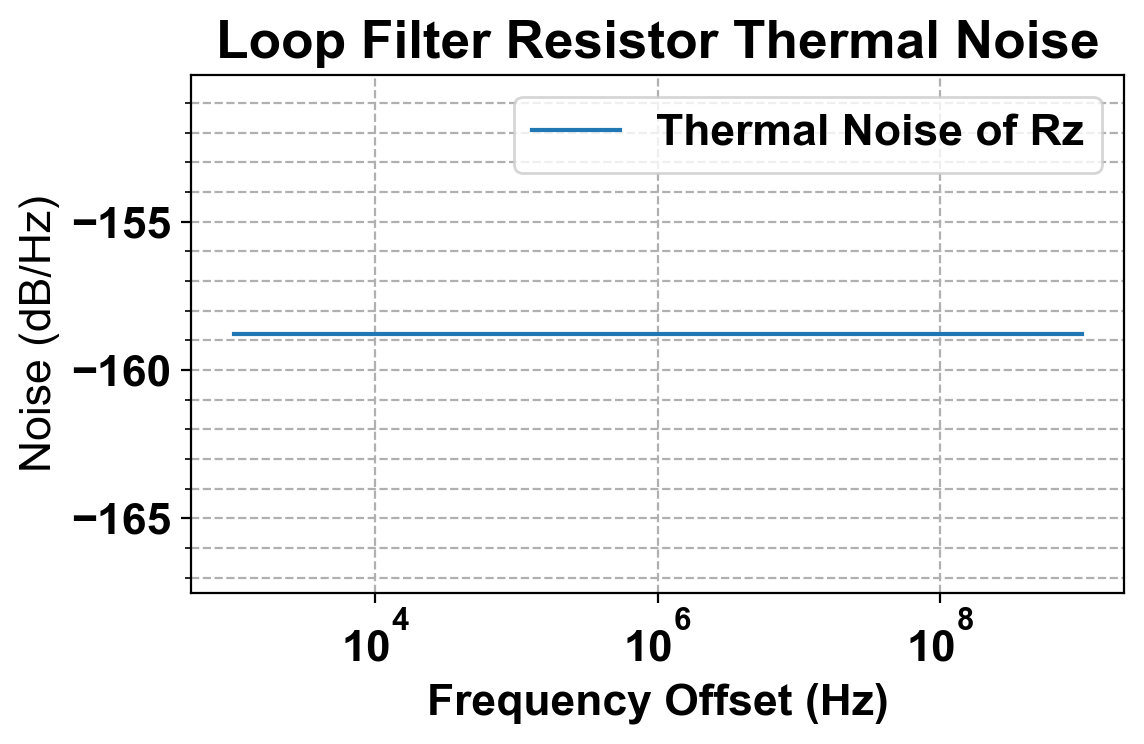

In [17]:
# Filter Resistor Noise
kB = 1.38e-23  # Boltzmann constant
T = 300  # Temperature in Kelvin
R = Rz  # Resistor value
# Thermal noise PSD
thermal_noise_Rz = 4 * kB * T * R  # in V^2/Hz
# Convert to dB/Hz
thermal_noise_Rz_dbHz = 10 * np.log10(thermal_noise_Rz) * np.ones_like(f)  # Flat noise PSD

plt.figure(figsize=(6, 4), dpi=200)
plt.minorticks_on()
plt.semilogx(f, thermal_noise_Rz_dbHz, label='Thermal Noise of Rz', color='tab:blue')
plt.title('Loop Filter Resistor Thermal Noise', fontweight='bold')
plt.xlabel('Frequency Offset (Hz)', fontweight='bold')
plt.ylabel('Noise (dB/Hz)')
plt.grid(True, linestyle='--', which='both')
plt.legend()
plt.tight_layout()
plt.show()

We then apply the transfer function to the noise sources

In [18]:
#Noise transfer function applied to the noise sources
output_phase_noise_ref = NTF_in_mag_db + phase_noise_ref
output_phase_noise_cp = NTF_cp_mag_db + phase_noise_cp
output_phase_noise_Rz = NTF_Rz_mag_db + thermal_noise_Rz_dbHz
output_phase_noise_vco = NTF_vco_mag_db + phase_noise_vco

#Total Output Phase Noise
total_output_phase_noise = 10 * np.log10(
    10**(output_phase_noise_ref/10) +
    10**(output_phase_noise_cp/10) +
    10**(output_phase_noise_Rz/10) +
    10**(output_phase_noise_vco/10)
)

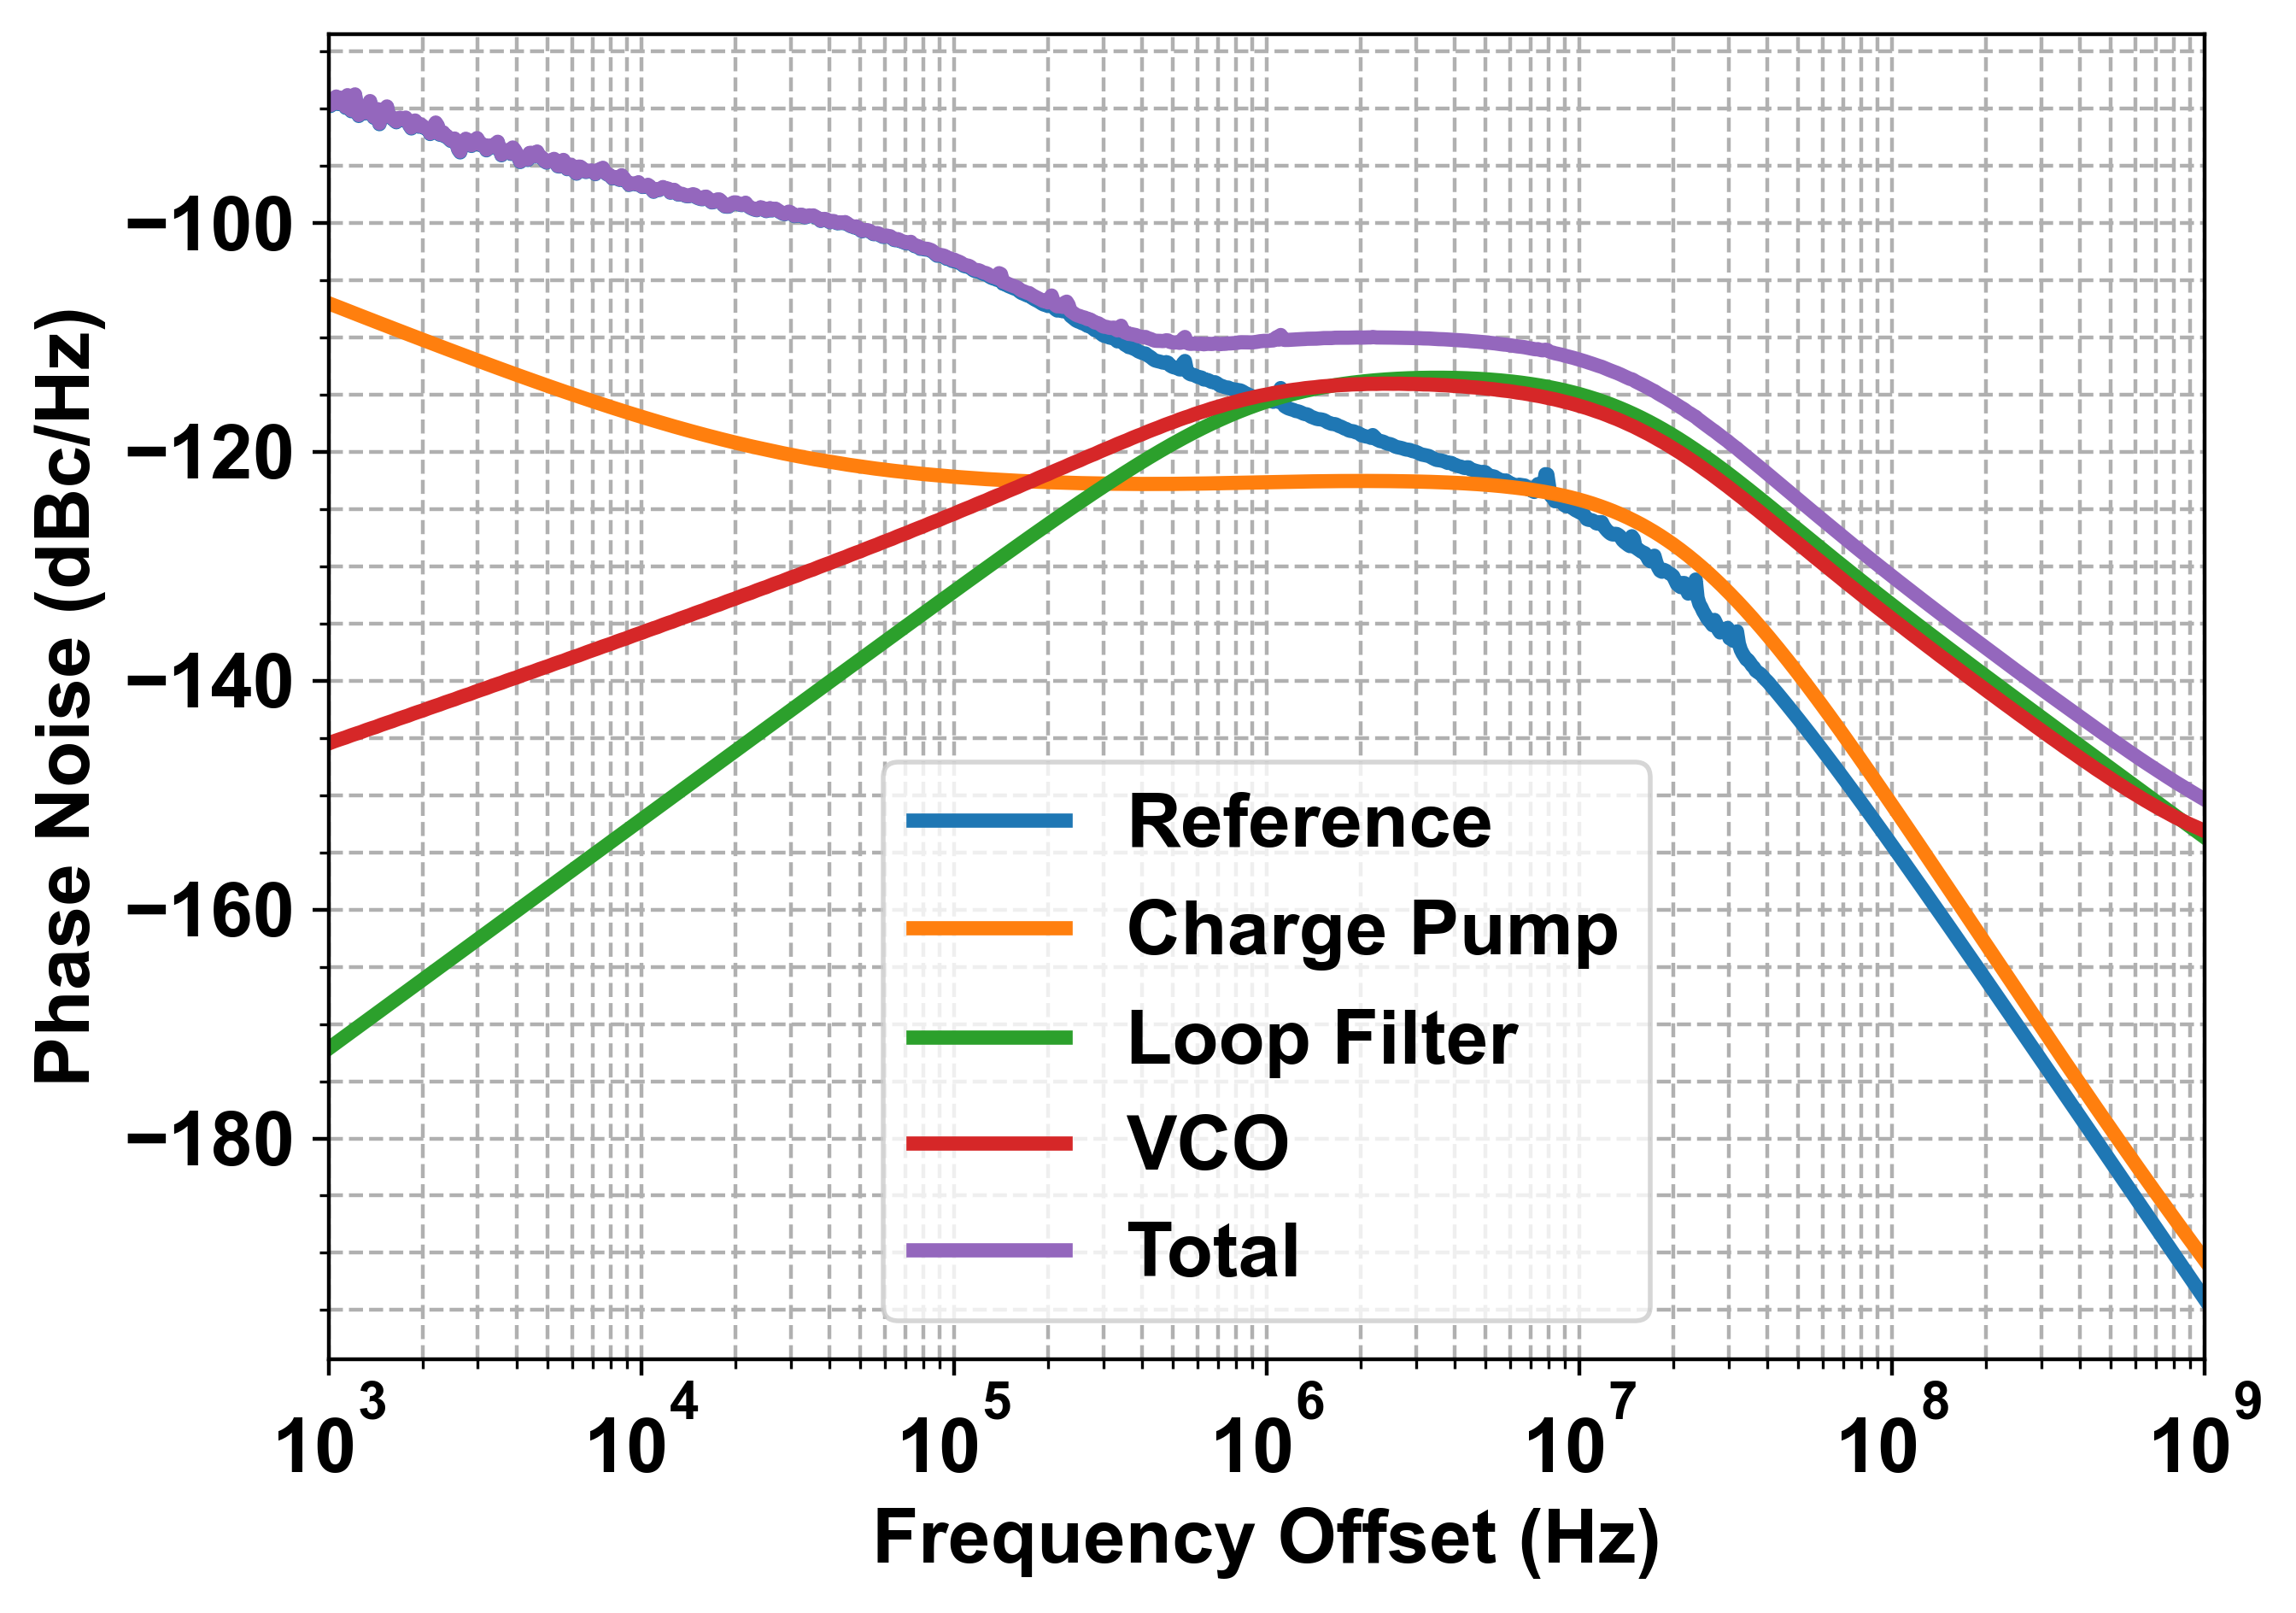

In [24]:
# Plot resulting output phase noise contributions
plt.figure(figsize=(7, 5), dpi=400)
plt.minorticks_on()
plt.semilogx(f, output_phase_noise_ref, label='Reference', color='tab:blue', linewidth=3)
plt.semilogx(f, output_phase_noise_cp, label='Charge Pump', color='tab:orange', linewidth=3)
plt.semilogx(f, output_phase_noise_Rz, label='Loop Filter', color='tab:green', linewidth=3)
plt.semilogx(f, output_phase_noise_vco, label='VCO', color='tab:red', linewidth=3)
plt.semilogx(f, total_output_phase_noise, label='Total', color='tab:purple', linewidth=3)   
#plt.title('PLL Output Phase Noise Contributions')
plt.xlabel('Frequency Offset (Hz)', fontweight='bold')
plt.ylabel('Phase Noise (dBc/Hz)', fontweight='bold')
plt.xlim([1e3, 1e9])
plt.grid(True, linestyle='--', which='both')
plt.legend()
plt.tight_layout()
plt.savefig('output_phase_noise_contributions.pdf', dpi=400)
plt.show()

Jitter calculations

In [18]:
# Jitter Calculation 
# Integrate total output phase noise to get RMS jitter
f_lower = 1e3  # Lower integration limit (1 kHz)
f_upper = 1e7  # Upper integration limit (10 MHz)

# Jitter Per Noise Source
def integrate_phase_noise(f, phase_noise_dbHz, f_lower, f_upper):
    # Convert dB/Hz to linear scale
    phase_noise_linear = 10**(phase_noise_dbHz / 10)
    # Create a mask for the integration limits
    mask = (f >= f_lower) & (f <= f_upper)
    # Integrate using trapezoidal rule
    integrated_noise = np.trapezoid(phase_noise_linear[mask], f[mask])
    rms_jitter_rad = np.sqrt(integrated_noise)
    return rms_jitter_rad


rms_jitter_ref_rad = integrate_phase_noise(f, output_phase_noise_ref, f_lower, f_upper)
rms_jitter_cp_rad = integrate_phase_noise(f, output_phase_noise_cp, f_lower, f_upper)
rms_jitter_Rz_rad = integrate_phase_noise(f, output_phase_noise_Rz, f_lower, f_upper)
rms_jitter_vco_rad = integrate_phase_noise(f, output_phase_noise_vco, f_lower, f_upper)
rms_jitter_total_rad = integrate_phase_noise(f, total_output_phase_noise, f_lower, f_upper)
rms_jitter_ref = (rms_jitter_ref_rad / (2 * np.pi * f0))
rms_jitter_cp = (rms_jitter_cp_rad / (2 * np.pi * f0))
rms_jitter_Rz = (rms_jitter_Rz_rad / (2 * np.pi * f0))
rms_jitter_vco = (rms_jitter_vco_rad / (2 * np.pi * f0))
rms_jitter_total = (rms_jitter_total_rad / (2 * np.pi * f0))
print('RMS Jitter Contributions:')
print('Reference Oscillator: ' + si_format(rms_jitter_ref) + 's')
print('Charge Pump: ' + si_format(rms_jitter_cp) + 's')
print('Loop Filter Resistor: ' + si_format(rms_jitter_Rz) + 's')
print('VCO: ' + si_format(rms_jitter_vco) + 's')
print('Total: ' + si_format(rms_jitter_total) + 's')
# End of PLL model with custom values

RMS Jitter Contributions:
Reference Oscillator: 330.6 fs
Charge Pump: 142.9 fs
Loop Filter Resistor: 386.5 fs
VCO: 360.9 fs
Total: 639.8 fs
